In [1]:
!pip cache purge

Files removed: 0


In [2]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import datetime
import tensorflow as tf

2025-09-27 09:46:57.925069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758966418.146261      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758966418.209496      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**DATA LOAD**

In [4]:
data_path = "/kaggle/input/data-preprocessing/"
print(os.listdir(data_path))

['x_test.pkl', 'x_valid.pkl', 'y_train.pkl', '__results__.html', 'x_train.pkl', '__notebook__.ipynb', '__results___files', '__output__.json', 'y_test.pkl', 'label_names.csv', 'y_valid.pkl', 'custom.css']


In [5]:
with open(data_path + "x_train.pkl", "rb") as f:
    x_train = pickle.load(f)

with open(data_path + "y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open(data_path + "x_valid.pkl", "rb") as f:
    x_valid = pickle.load(f)

with open(data_path + "y_valid.pkl", "rb") as f:
    y_valid = pickle.load(f)

with open(data_path + "x_test.pkl", "rb") as f:
    x_test = pickle.load(f)

with open(data_path + "y_test.pkl", "rb") as f:
    y_test = pickle.load(f)


print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(782901, 32, 32, 1) (782901, 43)
(39690, 32, 32, 1) (39690, 43)
(113670, 32, 32, 1) (113670, 43)


In [6]:
print(f"Min value of x_train dataset: {x_train.min()}")
print(f"Max value of x_train dataset: {x_train.max()}")

print(f"Min value of x_valid dataset: {x_valid.min()}")
print(f"Max value of x_validdataset: {x_valid.max()}")

print(f"Min value of x_test dataset: {x_test.min()}")
print(f"Max value of x_test dataset: {x_test.max()}")

Min value of x_train dataset: -1.9063234329223633
Max value of x_train dataset: 255.0
Min value of x_valid dataset: -1.845461368560791
Max value of x_validdataset: 255.0
Min value of x_test dataset: -1.8758924007415771
Max value of x_test dataset: 255.0


In [7]:
# Read classes
label_path = os.path.join(data_path, 'label_names.csv')
labels = pd.read_csv(label_path)
num_classes = len(labels)

print(labels)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

**MODEL DEFINITION AND HYPERPARAMETER OPTIMIZATION**

In [8]:
def create_cnn_model(learning_rate=0.001):
    """
    Creates the CNN model structure for tuning purposes.
    """
    model = Sequential([
        # Grayscale Input (32, 32, 1)
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [9]:
custom_model = create_cnn_model(learning_rate=0.001)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758966448.553256      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
# Parameters to test
learning_rates = [0.0005, 0.0001]
batch_sizes = [32, 64] 
test_epoch_no = 2

results = []

print("\n" + "="*60)
print("STARTING SEQUENTIAL HYPERPARAMETER SWEEP (Resource Safe)")
print("="*60)

# Data Augmentation setup (needed for the sweep)
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
valid_datagen = ImageDataGenerator()

# Loop through all combinations (runs sequentially)
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n--- Trial: LR={lr}, Batch Size={bs} ---")

        # Create a FRESH model instance for each trial
        trial_model = create_cnn_model(learning_rate=lr) 
        
        # Train the model
        history_sweep = trial_model.fit(
            train_datagen.flow(x_train, y_train, batch_size=bs),
            validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=bs),
            epochs=test_epoch_no,
            callbacks=[EarlyStopping(monitor='val_loss', patience=2, verbose=0)], 
            verbose=0
        )

        # Record results
        best_val_acc = max(history_sweep.history['val_accuracy'])
        
        results.append({
            'Learning Rate': lr,
            'Batch Size': bs,
            f'Max Val Acc (in {test_epoch_no} epochs)': best_val_acc
        })
        print(f"  -> Trial complete. Max Validation Accuracy: {best_val_acc:.4f}")


STARTING SEQUENTIAL HYPERPARAMETER SWEEP (Resource Safe)

--- Trial: LR=0.0005, Batch Size=32 ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1758966455.381172      66 service.cc:148] XLA service 0x7ac720002680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758966455.382204      66 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758966455.954840      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758966460.309209      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  -> Trial complete. Max Validation Accuracy: 0.7254

--- Trial: LR=0.0005, Batch Size=64 ---
  -> Trial complete. Max Validation Accuracy: 0.7333

--- Trial: LR=0.0001, Batch Size=32 ---
  -> Trial complete. Max Validation Accuracy: 0.7299

--- Trial: LR=0.0001, Batch Size=64 ---
  -> Trial complete. Max Validation Accuracy: 0.7169


In [11]:
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by=f'Max Val Acc (in {test_epoch_no} epochs)', ascending=False)

# Extract best parameters
best_params = results_df_sorted.iloc[0]
best_lr = best_params['Learning Rate']
best_batch_size = int(best_params['Batch Size'])

print("\n" + "*"*60)
print(f"Optimal LR found: {best_lr}")
print(f"Optimal Batch Size found: {best_batch_size}")
print("*"*60)


************************************************************
Optimal LR found: 0.0005
Optimal Batch Size found: 64
************************************************************


**MODEL TRAINING**

In [12]:
#!rm -rf /kaggle/working

In [13]:
# Use the optimal LR to create the new Adam optimizer instance
optimal_optimizer = Adam(learning_rate=best_lr)

# Re-compile your main model ('custom_model') with the optimized learning rate
custom_model.compile(
    optimizer=optimal_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

custom_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,187,531 (8.34 MB)

 Trainable params: 2,186,123 (8.34 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [14]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [15]:
checkpoint_filepath = "best_model.keras"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

In [16]:
# TensorBoard log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    checkpoint,
    tensorboard_callback
]

In [17]:
# Check if a checkpoint exists
if os.path.exists(checkpoint_filepath):
    print(f"✅ Checkpoint found at {checkpoint_filepath}. Loading model and continuing training...")
    try:
        # Load the entire model, including optimizer state
        custom_model = load_model(checkpoint_filepath)
        print("Model loaded successfully. Summary:")
        custom_model.summary()
    except Exception as e:
        print(f"❌ Error loading model: {e}. Re-creating model from scratch.")
        # If loading fails (e.g., due to compatibility issues), re-create the model
        custom_model = create_cnn_model(learning_rate=0.0005) 
        custom_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
else:
    print(f"🛑 No checkpoint found at {checkpoint_filepath}. Starting training from scratch.")
    # Re-compile your main model ('custom_model') with the optimized learning rate (already done in your script)
    optimal_optimizer = Adam(learning_rate=0.0005)
    custom_model = create_cnn_model(learning_rate=0.0005) # Ensure it's a fresh model if starting new
    custom_model.compile(
        optimizer=optimal_optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    custom_model.summary()


🛑 No checkpoint found at best_model.keras. Starting training from scratch.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,187,531 (8.34 MB)

 Trainable params: 2,186,123 (8.34 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [18]:
epochs = 50 

history_final = custom_model.fit(
    train_datagen.flow(x_train, y_train, batch_size=best_batch_size),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=best_batch_size),
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
12231/12233 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4573 - loss: 2.1822

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.72001, saving model to best_model.keras
12233/12233 ━━━━━━━━━━━━━━━━━━━━ 255s 20ms/step - accuracy: 0.4573 - loss: 2.1821 - val_accuracy: 0.7200 - val_loss: 1.0704 - learning_rate: 5.0000e-04
Epoch 2/50
12232/12233 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6842 - loss: 1.2241
Epoch 2: val_accuracy improved from 0.72001 to 0.72454, saving model to best_model.keras
12233/12233 ━━━━━━━━━━━━━━━━━━━━ 240s 20ms/step - accuracy: 0.6842 - loss: 1.2241 - val_accuracy: 0.7245 - val_loss: 1.0587 - learning_rate: 5.0000e-04
Epoch 3/50
12232/12233 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6946 - loss: 1.1781
Epoch 3: val_accuracy improved from 0.72454 to 0.73311, saving model to best_model.keras
12233/12233 ━━━━━━━━━━━━━━━━━━━━ 236s 19ms/step - accuracy: 0.6946 - loss: 1.1781 - val_accuracy: 0.7331 - val_loss: 1.0424 - learning_rate: 5.0000e-04
Epoch 4/50
12232/12233 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6991 - loss: 1.1589
Epoch 

**TRAINING RESULTS**

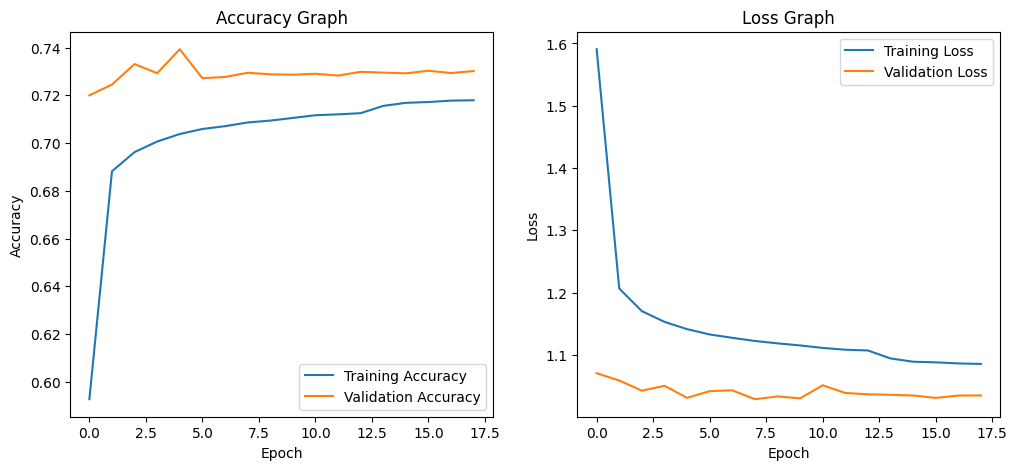

In [19]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot (Used to evaluate overfitting/underfitting)
plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**MODEL EVALUATION**

In [20]:
# Final Performance on Test Set
test_loss, test_accuracy = custom_model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set Loss: {test_loss:.4f}")


Test Set Accuracy: 0.7220
Test Set Loss: 1.0492


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

CLASSIFICATION REPORT
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.74      0.72      0.73       540
                              Speed limit (30km/h)       0.92      0.76      0.83      6480
                              Speed limit (50km/h)       0.95      0.73      0.83      6750
                              Speed limit (60km/h)       0.78      0.70      0.74      4050
                              Speed limit (70km/h)       0.97      0.69      0.81      5940
                              Speed limit (80km/h)       0.94      0.69      0.80      5670
                       End of speed limit (80km/h)       0.98      0.67      0.80      1350
                             Speed limit (100km/h)       0.95      0.68      0.79      4050
                             Speed limit (120km/h)       0.94      0.68      0.79      4050
             

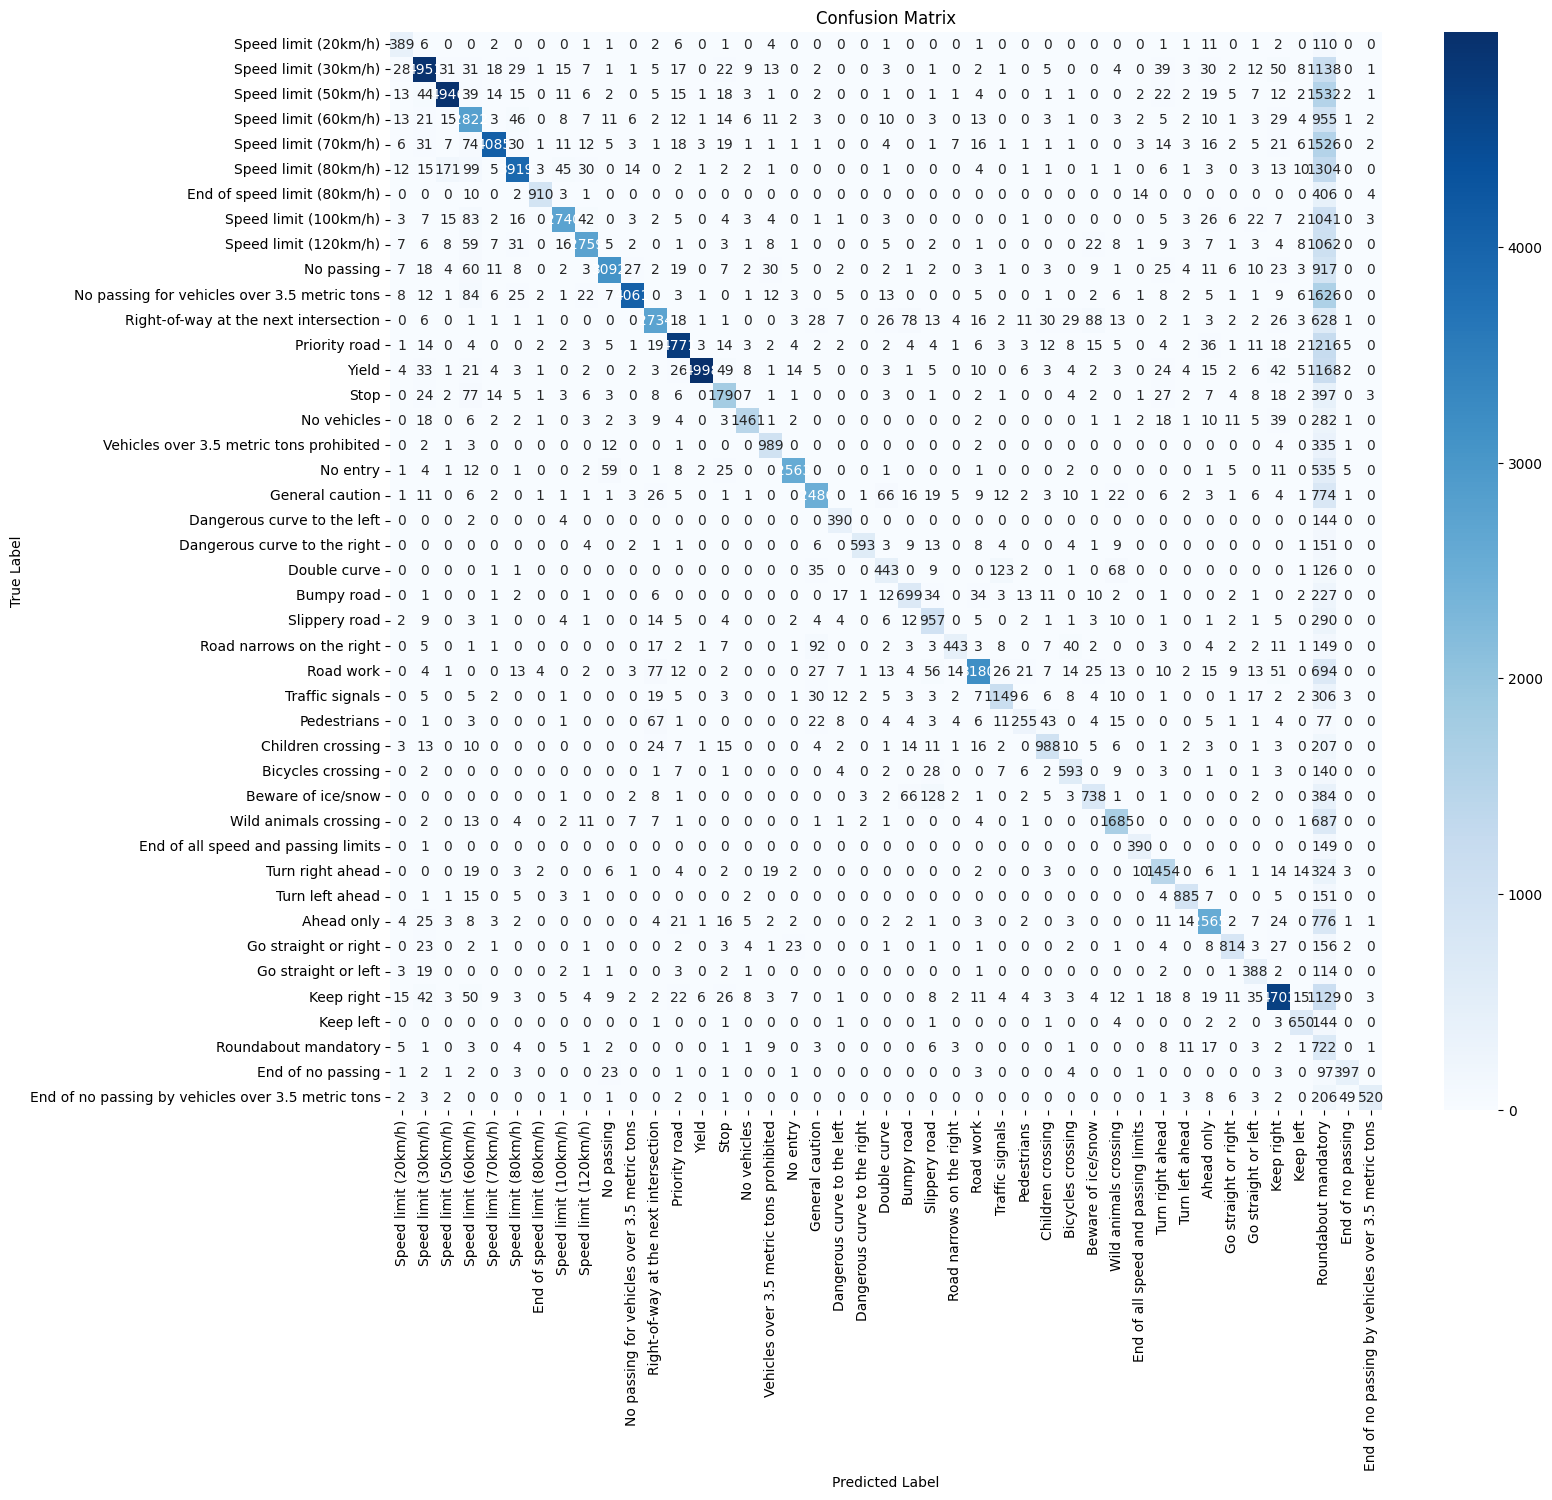

In [21]:
# Confusion Matrix & Classification Report

# Get predictions
y_pred_probs = custom_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true_classes, y_pred_classes, target_names=labels['SignName'].tolist()))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels['SignName'].tolist(), 
            yticklabels=labels['SignName'].tolist())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()